In [2]:
import os
import numpy as np
import pandas as pd
import laspy
import json
import geopandas as gpd

In [5]:
basePath = "/home/jaumeasensio/Downloads/Estudi Marc/"

In [7]:
lazFiles = os.listdir("/home/jaumeasensio/Downloads/Estudi Marc/")
lasDF_list = []
for file in lazFiles:
    lasPath = basePath + file
    lasDF = laspy.read(lasPath)
    print(len(lasDF.xyz))
    lasDF_list.append(lasDF.xyz)

# Concatenate all DataFrames in the list to create a single DataFrame
lasCoords = np.concatenate(lasDF_list)
print(len(lasCoords))


47748446
29892952
77641398


In [21]:
bounds = [446371-100, 4610110-100, 446371+100, 4610110+100]

selectedCoords = lasCoords[np.where((lasCoords[:,0] > bounds[0]) & (lasCoords[:,1] > bounds[1]) & (lasCoords[:,0] < bounds[2]) & (lasCoords[:,1] < bounds[3]))]
len(selectedCoords)

1748973

# Now we start with creating the DEM

In [45]:
import pygmt
spacing = 0.25
region = pygmt.info(data=selectedCoords, spacing=spacing)
df_trimmed = pygmt.blockmedian(data=selectedCoords, T=0.99, spacing = spacing, region = region)
df_trimmed = pygmt.blockmean(data=selectedCoords, spacing = spacing, region = region)
df_trimmed = df_trimmed.rename(columns={0:"x",1:"y",2:"z"})
df_trimmed

,x,y,z
0,446271.050000,4.610210e+06,202.613000
1,446272.296000,4.610210e+06,200.695500
2,446272.764000,4.610210e+06,200.634000
3,446273.221000,4.610210e+06,200.638000
4,446273.721500,4.610210e+06,200.715000
...,...,...,...
597510,446469.405000,4.610010e+06,206.749000
597511,446469.853000,4.610010e+06,206.935000
597512,446469.988333,4.610010e+06,207.049667
597513,446470.161000,4.610010e+06,207.164000


In [40]:
grid = pygmt.surface(data=selectedCoords, spacing=spacing, region = region, tension = 0) # tension = 0.35

surface [WARNING]: 1151430 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


# Now let's process it

In [41]:
# Extract x, y coordinates and z values
x = grid.x.values  # Extract x-coordinates
y = grid.y.values  # Extract y-coordinates
Z = grid.values    # Extract grid values (z)

# Create a numpy meshgrid
X, Y = np.meshgrid(x, y)
Z.shape



(801, 801)

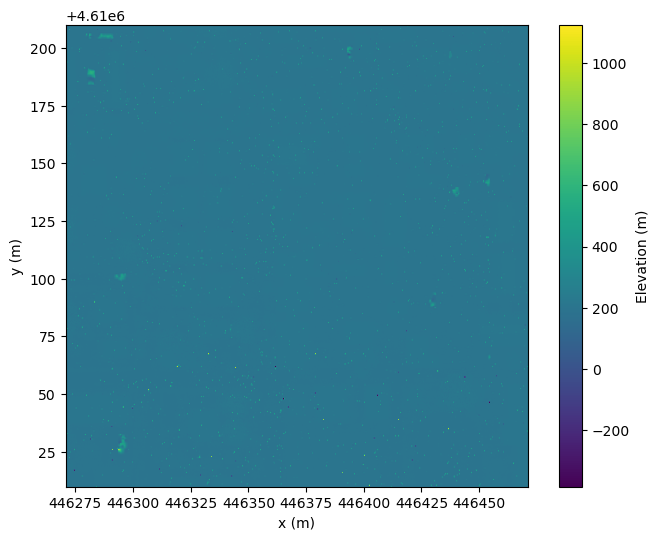

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(X, Y, Z, cmap='viridis', shading='auto')

fig.colorbar(c, ax=ax, label="Elevation (m)")
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_aspect("equal", adjustable='box')
# plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Shading/DSM.png",bbox_inches='tight')
plt.show()

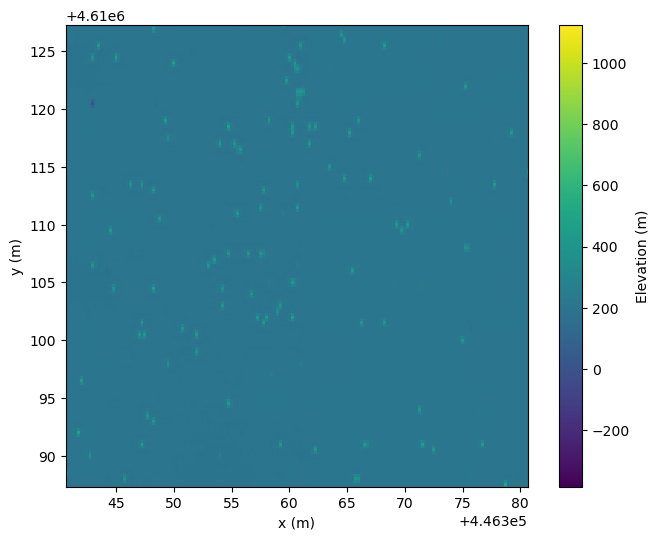

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(X, Y, Z, cmap='viridis', shading='auto')
fig.colorbar(c, ax=ax, label="Elevation (m)")

# Adjust axis limits and labels if needed
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')


point = [446360.66223639436, 4610107.310317169]
# Show the plot
minSize=20
ax.set_xlim(point[0]-minSize, point[0]+minSize)
ax.set_ylim(point[1]-minSize, point[1]+minSize)
ax.set_aspect("equal", adjustable='box')
# plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Shading/Sampling.png",bbox_inches='tight')
plt.show()

In [46]:
point = [446360.66223639436, 4610107.310317169]
Z_point = Z[401, 401]
Z_point

np.float32(208.74155)

In [47]:
import math
import time
start = time.time()
azimuthAngle = np.zeros(X.shape)
azimuthAngle = np.arctan2(X[:,:] - point[0], Y[:,:] - point[1])*180/math.pi
azimuthAngle = np.where(azimuthAngle < 0, azimuthAngle + 360, azimuthAngle)
azimuthAngle = np.round(azimuthAngle).astype(int)


tiltangle = np.zeros(X.shape)
# # This can be further optimized by applying a mask on the azimuth, but that means that the angles need to be handled in case there is a missing orientation
# mask = (azimuthAngle >= 60) & (azimuthAngle <= 300) & (Z >= Z_point)
# distance = np.sqrt((X[mask] - point[0])**2 + (Y[mask] - point[1])**2)
# tiltangle[mask] = np.arctan2((Z[mask] - Z_point), distance) * 180 / math.pi

distance = np.sqrt((X[:,:] - point[0])**2 + (Y[:,:] - point[1])**2)
tiltangle = np.arctan2((Z[:,:] - Z_point), distance[:,:])*180/math.pi
tiltangle = np.maximum(tiltangle, 0)

print(time.time()-start)

0.018317461013793945


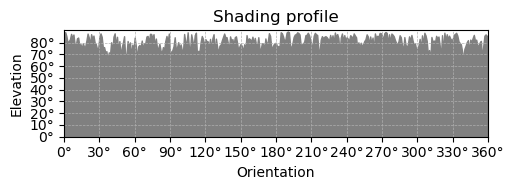

In [48]:
azimuthAngle_flat = azimuthAngle.ravel()
tiltangle_flat = tiltangle.ravel()
df = pd.DataFrame({
    'azimuth': azimuthAngle_flat,
    'tiltangle': tiltangle_flat
})

# Group by azimuth and get the maximum tiltangle for each azimuth
max_tilt_df = df.groupby('azimuth')['tiltangle'].max().reset_index()

# plt.plot(azimuthAngle_flat, tiltangle_flat)
plt.figure(figsize=(9, 2)) 
plt.fill_between(max_tilt_df.azimuth, 0, max_tilt_df.tiltangle, color="gray")
plt.title('Shading profile')
plt.xlabel('Orientation')
plt.ylabel('Elevation')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, 360)
plt.ylim(0, max(max_tilt_df.tiltangle) + 1)
xticks = range(0, 361, 30)  # Tick every 30°
yticks = range(0, int(max(max_tilt_df.tiltangle)) + 1, 10)  # Tick every 5°
plt.xticks(xticks, [f"{tick}°" for tick in xticks])
plt.yticks(yticks, [f"{tick}°" for tick in yticks])
plt.tight_layout()
plt.gca().set_aspect("equal", adjustable='box')
# plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Shading/ShadingProfilePoint.pdf", dpi=300,bbox_inches='tight')
plt.show()

In [31]:
import math
start = time.time()
azimuthAngle = np.zeros(X.shape)
azimuthAngle = np.arctan2(X[:,:] - point[0], Y[:,:] - point[1])*180/math.pi
azimuthAngle = np.where(azimuthAngle < 0, azimuthAngle + 360, azimuthAngle)
azimuthAngle = np.round(azimuthAngle).astype(int)


tiltangle = np.zeros(X.shape)
# This can be further optimized by applying a mask on the azimuth, but that means that the angles need to be handled in case there is a missing orientation
mask = (azimuthAngle >= 60) & (azimuthAngle <= 300) & (Z >= Z_point)
distance = np.sqrt((X[mask] - point[0])**2 + (Y[mask] - point[1])**2)
tiltangle[mask] = np.arctan2((Z[mask] - Z_point), distance) * 180 / math.pi

print(time.time()-start)

0.037862539291381836


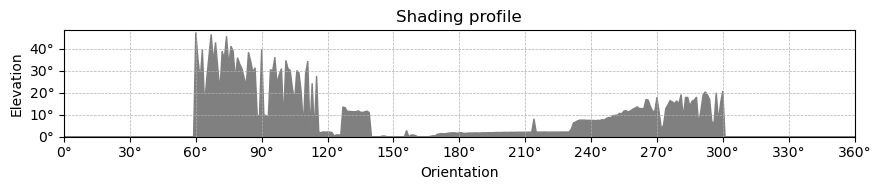

In [32]:
azimuthAngle_flat = azimuthAngle.ravel()
tiltangle_flat = tiltangle.ravel()
df = pd.DataFrame({
    'azimuth': azimuthAngle_flat,
    'tiltangle': tiltangle_flat
})

# Group by azimuth and get the maximum tiltangle for each azimuth
max_tilt_df = df.groupby('azimuth')['tiltangle'].max().reset_index()

# plt.plot(azimuthAngle_flat, tiltangle_flat)
plt.figure(figsize=(9, 2)) 
plt.fill(max_tilt_df.azimuth, max_tilt_df.tiltangle, c="gray")
plt.title('Shading profile')
plt.xlabel('Orientation')
plt.ylabel('Elevation')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, 360)
plt.ylim(0, max(max_tilt_df.tiltangle) + 1)
xticks = range(0, 361, 30)  # Tick every 30°
yticks = range(0, int(max(max_tilt_df.tiltangle)) + 1, 10)  # Tick every 5°
plt.xticks(xticks, [f"{tick}°" for tick in xticks])
plt.yticks(yticks, [f"{tick}°" for tick in yticks])
plt.tight_layout()
plt.gca().set_aspect("equal", adjustable='box')
# plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Shading/ShadingProfilePoint.pdf", dpi=300,bbox_inches='tight')
plt.show()

/tmp/ipykernel_249738/3430635935.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels([f"{tick:.0f}°" for tick in cbar_ticks])  # Add ° to each tick


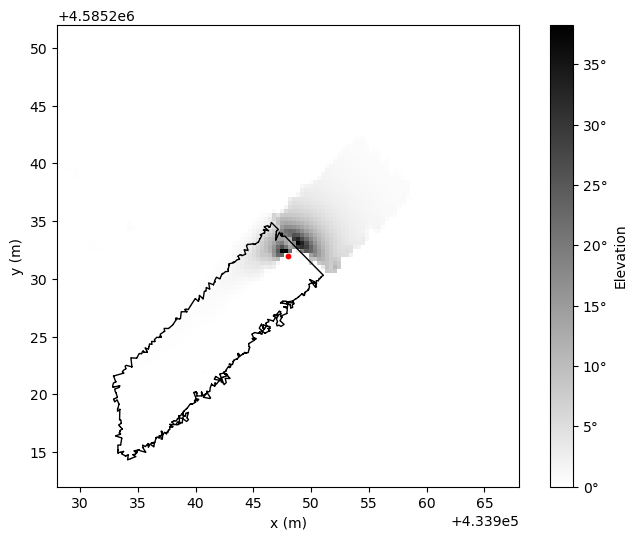

In [273]:
from mpl_interactions import panhandler, zoom_factory
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(X, Y, tiltangle, cmap='gray_r', shading='auto')
#c = ax.pcolormesh(X, Y, np.log(tiltangle), cmap='gray_r', shading='auto')
cb = fig.colorbar(c, ax=ax, label="Elevation")

# Customize colorbar ticks
cbar_ticks = cb.ax.get_yticks()  # Get current colorbar ticks
cb.ax.set_yticklabels([f"{tick:.0f}°" for tick in cbar_ticks])  # Add ° to each tick



# Plot the GeoDataFrame over the surface plot
planesGDF[planesGDF.cluster==clusterID].plot(ax=ax, color="None", edgecolor='black', linewidth=1)

# Adjust axis limits and labels if needed
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

minSize=20
ax.set_xlim(point[0]-minSize, point[0]+minSize)
ax.set_ylim(point[1]-minSize, point[1]+minSize)

ax.scatter(point[0], point[1], s=10, c="red")

zoom_factory(ax)
panhandler(fig)

# Show the plot
ax.set_aspect("equal", adjustable='box')
plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Shading/ShadingPoint.png",bbox_inches='tight')
plt.show()

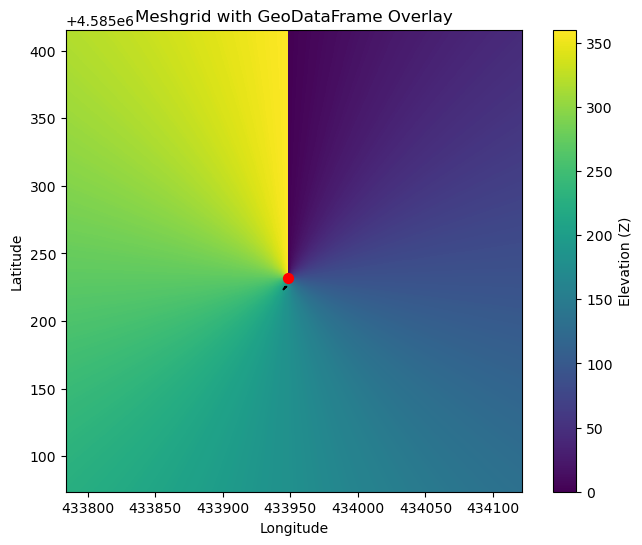

In [158]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(X, Y, azimuthAngle, cmap='viridis', shading='auto')
fig.colorbar(c, ax=ax, label="Elevation (Z)")


# Plot the GeoDataFrame over the surface plot
planesGDF[planesGDF.cluster==4].plot(ax=ax, color="None", edgecolor='black', linewidth=1)

# Adjust axis limits and labels if needed
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Meshgrid with GeoDataFrame Overlay')

ax.scatter(point[0], point[1], s=50, c="red")
# Show the plot
plt.show()

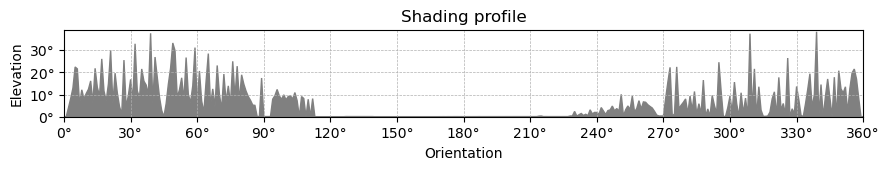

In [274]:
azimuthAngle_flat = azimuthAngle.ravel()
tiltangle_flat = tiltangle.ravel()
df = pd.DataFrame({
    'azimuth': azimuthAngle_flat,
    'tiltangle': tiltangle_flat
})

# Group by azimuth and get the maximum tiltangle for each azimuth
max_tilt_df = df.groupby('azimuth')['tiltangle'].max().reset_index()

# plt.plot(azimuthAngle_flat, tiltangle_flat)
plt.figure(figsize=(9, 2)) 
plt.fill(max_tilt_df.azimuth, max_tilt_df.tiltangle, c="gray")
plt.title('Shading profile')
plt.xlabel('Orientation')
plt.ylabel('Elevation')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, 360)
plt.ylim(0, max(max_tilt_df.tiltangle) + 1)
xticks = range(0, 361, 30)  # Tick every 30°
yticks = range(0, int(max(max_tilt_df.tiltangle)) + 1, 10)  # Tick every 5°
plt.xticks(xticks, [f"{tick}°" for tick in xticks])
plt.yticks(yticks, [f"{tick}°" for tick in yticks])
plt.tight_layout()
plt.gca().set_aspect("equal", adjustable='box')
# plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Shading/ShadingProfilePoint.pdf", dpi=300,bbox_inches='tight')
plt.show()

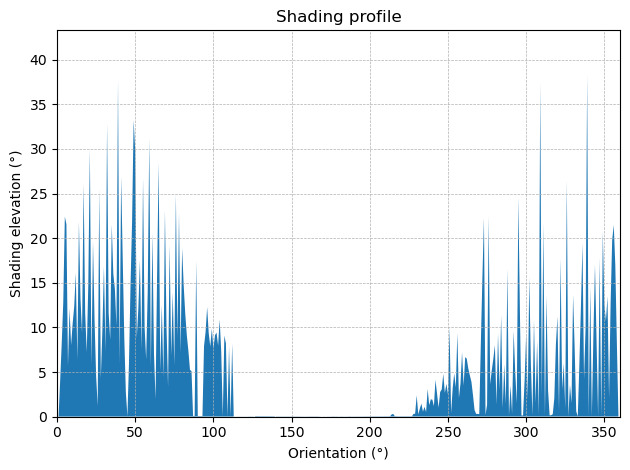

In [26]:
plt.fill(max_tilt_df.azimuth, max_tilt_df.tiltangle)
plt.title('Shading profile')
plt.xlabel('Orientation (°)')
plt.ylabel('Shading elevation (°)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, 360)
plt.ylim(0, max(max_tilt_df.tiltangle) + 5)
plt.tight_layout()
plt.show()

# Getting a shading map

In [275]:
shadingPath = basePath + "Results/Test_70_el Besòs i el Maresme/Parcels/4054901DF3845C/408/Shading/"
shadingFiles = ["1.csv", "2.csv", "3.csv"]

shadingProfiles = pd.DataFrame()

for shadingFile in shadingFiles:
    filePath = os.path.join(shadingPath, shadingFile)
    temp_df = pd.read_csv(filePath, header=None)  # Read the CSV file
    shadingProfiles = pd.concat([shadingProfiles, temp_df], ignore_index=True)  # Concatenate into the main dataframe

shadingProfiles['avg'] = shadingProfiles.iloc[:, 3:363].mean(axis=1)
shadingProfiles = shadingProfiles.rename(columns={0:"x", 1:"y"})
shadingProfiles

,x,y,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,avg
0,433946.0,4585233.0,21.68,90.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.263889
1,433946.0,4585234.0,21.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.966667
2,433947.0,4585234.0,21.75,90.0,0.0,0.0,0.0,16.0,12.0,0.0,...,4.0,0.0,0.0,5.0,16.0,0.0,0.0,0.0,0.0,12.091667
3,433944.0,4585232.0,21.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.213889
4,433945.0,4585232.0,21.66,90.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.588889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,433933.0,4585219.0,20.73,40.0,1.0,7.0,11.0,13.0,15.0,17.0,...,17.0,15.0,14.0,12.0,12.0,10.0,6.0,1.0,0.0,8.250000
235,433933.0,4585218.0,20.46,90.0,3.0,7.0,9.0,12.0,15.0,18.0,...,15.0,13.0,11.0,10.0,10.0,8.0,7.0,3.0,0.0,8.200000
236,433932.0,4585217.0,19.99,12.0,4.0,5.0,7.0,9.0,11.0,12.0,...,8.0,9.0,10.0,9.0,8.0,6.0,5.0,3.0,0.0,7.086111
237,433933.0,4585217.0,20.20,28.0,4.0,7.0,9.0,12.0,15.0,18.0,...,14.0,13.0,13.0,11.0,9.0,8.0,6.0,4.0,0.0,7.938889


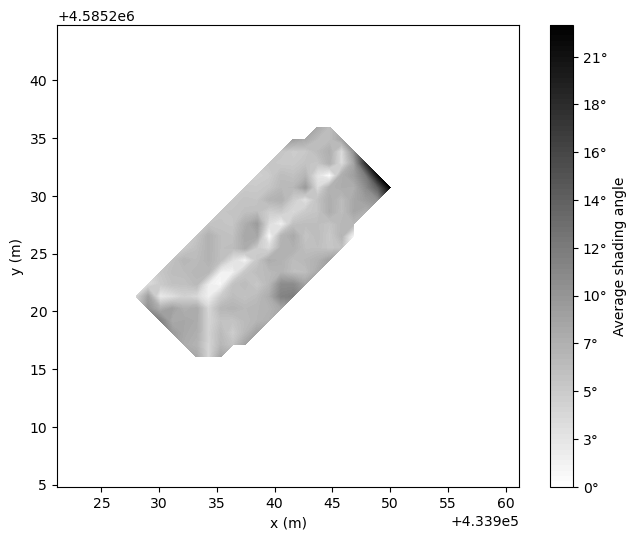

In [276]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Assuming shadingsProfiles is a dictionary-like object
x = shadingProfiles["x"]
y = shadingProfiles["y"]
z = shadingProfiles["avg"]

# Create a grid for x and y
xi = np.linspace(min(x), max(x), math.ceil(max(x)-min(x)))
yi = np.linspace(min(y), max(y), math.ceil(max(y)-min(y)))
xi, yi = np.meshgrid(xi, yi)

# Interpolate z onto the grid
zi = griddata((x, y), z, (xi, yi), method='cubic')

# Plot the mesh
fig, ax = plt.subplots(figsize=(8, 6))

heatmap = plt.contourf(xi, yi, zi, levels=100, cmap='gray_r')
cb = fig.colorbar(heatmap, ax=ax, label="Average shading angle")

cbar_ticks = cb.ax.get_yticks()  # Get current colorbar ticks
cb.ax.set_yticks(cbar_ticks)  # Ensure the same ticks are used
cb.ax.set_yticklabels([f"{tick:.0f}°" for tick in cbar_ticks])  # Add ° to each tick


# planesGDF[planesGDF.cluster == 4].plot(ax=ax, color="None", edgecolor='black', linewidth=1)

centroid = planesGDF[planesGDF.cluster==clusterID].centroid.values[0]
centroid = [centroid.x, centroid.y]
minSize=20
ax.set_xlim(centroid[0]-minSize, centroid[0]+minSize)
ax.set_ylim(centroid[1]-minSize, centroid[1]+minSize)

# Add axis labels and title
plt.xlabel("x (m)")
plt.ylabel("y (m)")

# Show the plot
ax.set_aspect("equal", adjustable='box')
plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Shading/ShadingWholeRoof.png",bbox_inches='tight')
plt.show()

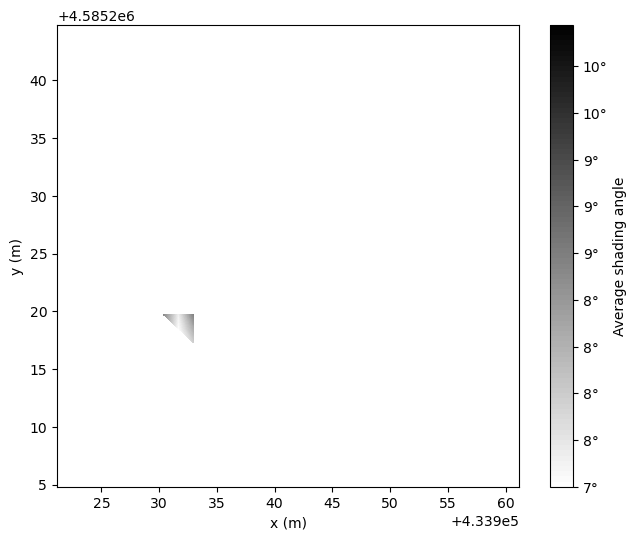

In [112]:
shadingFiles = ["3.csv"]
shadingPath = basePath + "Results/Test_70_el Besòs i el Maresme/Parcels/4054901DF3845C/408/Shading/"

shadingProfiles = pd.DataFrame()

for shadingFile in shadingFiles:
    filePath = os.path.join(shadingPath, shadingFile)
    temp_df = pd.read_csv(filePath, header=None)  # Read the CSV file
    shadingProfiles = pd.concat([shadingProfiles, temp_df], ignore_index=True)  # Concatenate into the main dataframe

shadingProfiles['avg'] = shadingProfiles.iloc[:, 3:363].mean(axis=1)
shadingProfiles = shadingProfiles.rename(columns={0:"x", 1:"y"})

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Assuming shadingsProfiles is a dictionary-like object
x = shadingProfiles["x"]
y = shadingProfiles["y"]
z = shadingProfiles["avg"]

# Create a grid for x and y
xi = np.linspace(min(x), max(x), math.ceil(max(x)-min(x)))
yi = np.linspace(min(y), max(y), math.ceil(max(y)-min(y)))
xi, yi = np.meshgrid(xi, yi)

# Interpolate z onto the grid
zi = griddata((x, y), z, (xi, yi), method='cubic')

# Plot the mesh
fig, ax = plt.subplots(figsize=(8, 6))

heatmap = plt.contourf(xi, yi, zi, levels=100, cmap='gray_r')
cb = fig.colorbar(heatmap, ax=ax, label="Average shading angle")

cbar_ticks = cb.ax.get_yticks()  # Get current colorbar ticks
cb.ax.set_yticks(cbar_ticks)  # Ensure the same ticks are used
cb.ax.set_yticklabels([f"{tick:.0f}°" for tick in cbar_ticks])  # Add ° to each tick


# planesGDF[planesGDF.cluster == 4].plot(ax=ax, color="None", edgecolor='black', linewidth=1)

centroid = planesGDF[planesGDF.cluster==clusterID].centroid.values[0]
centroid = [centroid.x, centroid.y]
minSize=20
ax.set_xlim(centroid[0]-minSize, centroid[0]+minSize)
ax.set_ylim(centroid[1]-minSize, centroid[1]+minSize)

# Add axis labels and title
plt.xlabel("x (m)")
plt.ylabel("y (m)")

# Show the plot
ax.set_aspect("equal", adjustable='box')
plt.show()

/tmp/ipykernel_249738/730122741.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels([f"{tick:.0f}°" for tick in cbar_ticks])  # Add ° to each tick


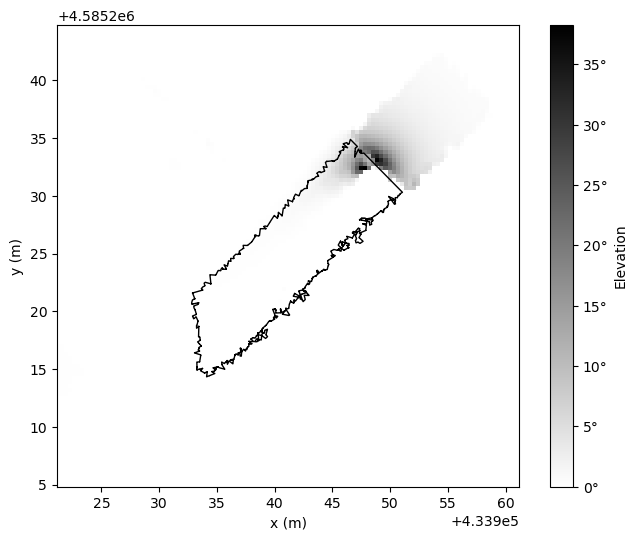

In [53]:
from mpl_interactions import panhandler, zoom_factory
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(X, Y, tiltangle, cmap='gray_r', shading='auto')
#c = ax.pcolormesh(X, Y, np.log(tiltangle), cmap='gray_r', shading='auto')
cb = fig.colorbar(c, ax=ax, label="Elevation")

# Customize colorbar ticks
cbar_ticks = cb.ax.get_yticks()  # Get current colorbar ticks
cb.ax.set_yticklabels([f"{tick:.0f}°" for tick in cbar_ticks])  # Add ° to each tick

centroid = planesGDF[planesGDF.cluster==clusterID].centroid.values[0]
centroid = [centroid.x, centroid.y]


# Plot the GeoDataFrame over the surface plot
planesGDF[planesGDF.cluster==clusterID].plot(ax=ax, color="None", edgecolor='black', linewidth=1)

# Adjust axis limits and labels if needed
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

minSize=20
ax.set_xlim(centroid[0]-minSize, centroid[0]+minSize)
ax.set_ylim(centroid[1]-minSize, centroid[1]+minSize)

# Show the plot
ax.set_aspect("equal", adjustable='box')
plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Shading/ShadingWholeRoof.png",bbox_inches='tight')
plt.show()

# Some previous tests

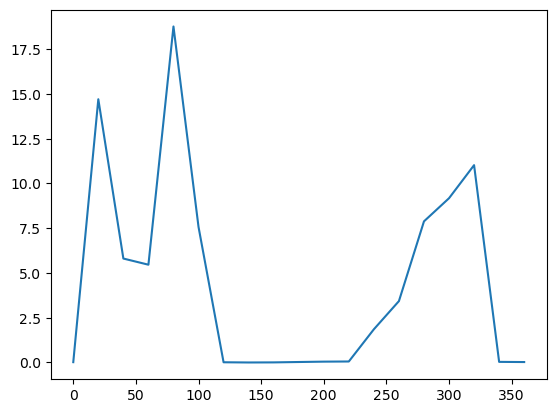

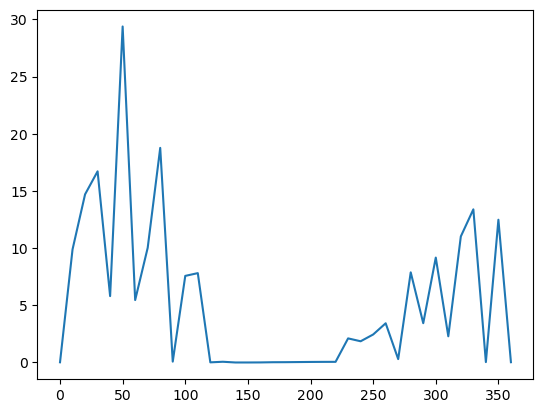

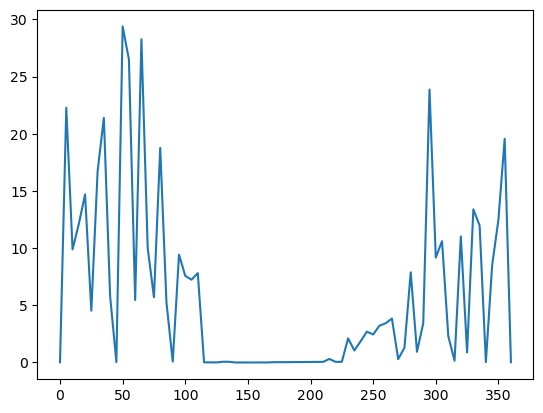

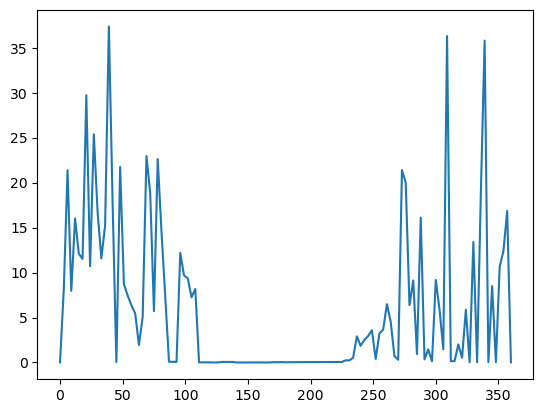

In [172]:
from scipy.interpolate import make_interp_spline, BSpline

xnew = np.linspace(max_tilt_df.azimuth.min(), max_tilt_df.azimuth.max(), 18+1) 
spl = make_interp_spline(max_tilt_df.azimuth, max_tilt_df.tiltangle, k=2)  # type: BSpline
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth)
plt.show()

xnew = np.linspace(max_tilt_df.azimuth.min(), max_tilt_df.azimuth.max(), 36+1) 
spl = make_interp_spline(max_tilt_df.azimuth, max_tilt_df.tiltangle, k=2)  # type: BSpline
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth)
plt.show()

xnew = np.linspace(max_tilt_df.azimuth.min(), max_tilt_df.azimuth.max(), 72+1) 
spl = make_interp_spline(max_tilt_df.azimuth, max_tilt_df.tiltangle, k=3)  # type: BSpline
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth)
plt.show()

xnew = np.linspace(max_tilt_df.azimuth.min(), max_tilt_df.azimuth.max(), 120+1) 
spl = make_interp_spline(max_tilt_df.azimuth, max_tilt_df.tiltangle, k=3)  # type: BSpline
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth)
plt.show()

# xnew = np.linspace(max_tilt_df.azimuth.min(), max_tilt_df.azimuth.max(), 180) 
# spl = make_interp_spline(max_tilt_df.azimuth, max_tilt_df.tiltangle, k=3)  # type: BSpline
# power_smooth = spl(xnew)
# plt.plot(xnew, power_smooth)

# xnew = np.linspace(max_tilt_df.azimuth.min(), max_tilt_df.azimuth.max(), 360) 
# spl = make_interp_spline(max_tilt_df.azimuth, max_tilt_df.tiltangle, k=3)  # type: BSpline
# power_smooth = spl(xnew)
# plt.plot(xnew, power_smooth)

# Max jumping

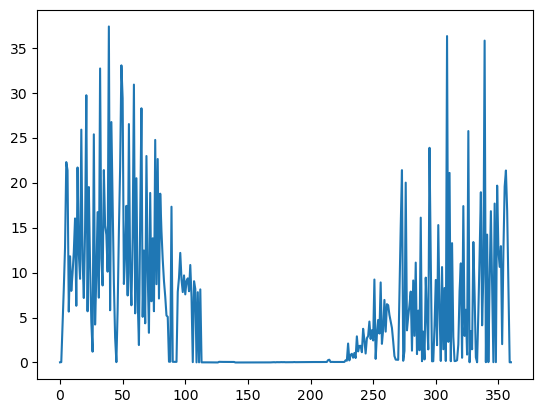

In [173]:
plt.plot(max_tilt_df.azimuth, max_tilt_df.tiltangle)
plt.show()

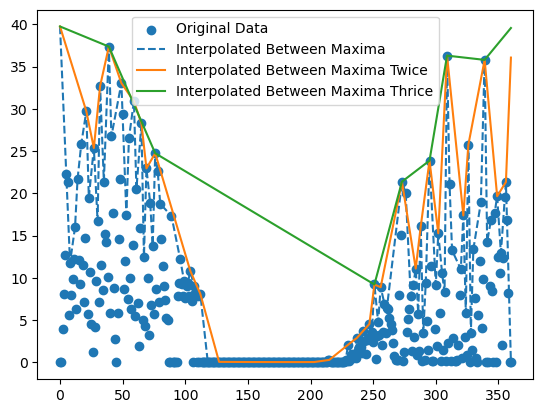

In [174]:
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

def getLocalMaxima(data):
    local_maxima_indices = []
    for i in range(len(data)):
        prev_idx = (i - 1) % len(data)
        next_idx = (i + 1) % len(data)
        if data[i] > data[prev_idx] and data[i] > data[next_idx]:
            local_maxima_indices.append(i)

    local_maxima_indices = np.array(local_maxima_indices)
    local_maxima_values = data[local_maxima_indices]

    # Include all indices for a complete interpolation
    full_indices = np.arange(len(data) + 1)
    full_maxima_indices = np.concatenate((local_maxima_indices, [local_maxima_indices[0] + len(data)]))
    full_maxima_values = np.concatenate((local_maxima_values, [local_maxima_values[0]]))

    # Interpolate between local maxima
    interpolator = interp1d(full_maxima_indices, full_maxima_values, kind='linear', fill_value='extrapolate')
    # interpolator = CubicSpline(full_maxima_indices, full_maxima_values, bc_type='periodic')
    interpolated_values = interpolator(np.arange(len(data)))

    return interpolated_values

interpolated_values = getLocalMaxima(max_tilt_df.tiltangle.values)
interpolated_values2 = getLocalMaxima(interpolated_values)
interpolated_values3 = getLocalMaxima(interpolated_values2)

plt.scatter(max_tilt_df.azimuth, max_tilt_df.tiltangle, label='Original Data', marker='o')
plt.plot(max_tilt_df.azimuth, interpolated_values, label='Interpolated Between Maxima', linestyle="--")
plt.plot(max_tilt_df.azimuth, interpolated_values2, label='Interpolated Between Maxima Twice')
plt.plot(max_tilt_df.azimuth, interpolated_values3, label='Interpolated Between Maxima Thrice')
plt.legend()
plt.show()

In [114]:
interpolated_values2

array([35.72205212, 35.57483973, 35.42762735, 35.28041496, 35.13320258,
       34.9859902 , 34.83877781, 34.69156543, 34.54435305, 34.39714066,
       34.24992828, 34.10271589, 33.95550351, 33.80829113, 33.66107874,
       33.51386636, 33.36665397, 33.21944159, 33.07222921, 32.92501682,
       32.77780444, 33.36552074, 33.95323705, 34.54095335, 35.12866966,
       35.71638596, 35.79397974, 35.87157352, 35.94916729, 36.02676107,
       36.10435485, 36.18194863, 36.25954241, 36.33713619, 36.41472996,
       36.89284149, 37.37095302, 37.84906455, 38.32717608, 38.85282974,
       39.37848341, 39.90413707, 40.42979073, 40.9554444 , 41.48109806,
       42.00675173, 42.53240539, 43.05805905, 43.58371272, 43.85759412,
       44.13147552, 44.40535692, 44.67923832, 44.95311973, 45.22700113,
       45.50088253, 45.77476393, 46.04864533, 45.36553902, 44.68243272,
       43.99932641, 43.3162201 , 42.63311379, 41.95000748, 41.02724904,
       40.10449059, 39.18173215, 38.25897371, 37.33621526, 36.41

# Implement all as a function

In [210]:
import os
import numpy as np
import pandas as pd
import laspy
import json
import geopandas as gpd
import pygmt
from shapely.geometry import Point, MultiPolygon
import math
import shutil

In [223]:
# Parcel level: load necessary Lidar

lidarCellsInfoFile = basePath + "Results/Test_70_el Besòs i el Maresme/necessaryLiDAR_Buffer100.txt"
lidarInfoDF = pd.read_csv(lidarCellsInfoFile)
lidarInfoDF["files"] = lidarInfoDF["files"].apply(json.loads)
lidarInfoDF["bounds"] = lidarInfoDF["bounds"].apply(json.loads)
lidarInfoDF = lidarInfoDF.sort_values("files").reset_index(drop=True)

basePath = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/"
neighborhood = "Test_70_el Besòs i el Maresme"
parcelsFolder = basePath + "/Results/" + neighborhood + "/Parcels/"

selectedParcels = lidarInfoDF[lidarInfoDF['REFCAT'].isin(os.listdir(parcelsFolder))].reset_index(drop=True)

previousFileList = []

def create_output_folder(directory, deleteFolder = False):
    if not(os.path.isdir(directory)):
        os.makedirs(directory)
    else:
        if(deleteFolder):
            shutil.rmtree(directory)
            os.makedirs(directory)

def load_necessary_laz(lidarFolder, fileList):
    lasDF_list = []
    for file in fileList:
        lasPath = lidarFolder + file + ".laz"
        lasDF = laspy.read(lasPath)
        lasDF_list.append(lasDF.xyz)

    lasCoords = np.concatenate(lasDF_list)
    return lasCoords

def getGrid(selectedCoords):
    spacing = 0.1
    region = pygmt.info(data=selectedCoords, spacing=spacing)
    df_trimmed = pygmt.blockmedian(data=selectedCoords, T=0.99, spacing = spacing, region = region)
    df_trimmed = df_trimmed.rename(columns={0:"x",1:"y",2:"z"})
    grid = pygmt.surface(x=df_trimmed.x, y=df_trimmed.y, z=df_trimmed.z, spacing=spacing, region = region, T = 0.35) #T: check bibliography

    x = grid.x.values  # Extract x-coordinates
    y = grid.y.values  # Extract y-coordinates
    Z = grid.values    # Extract grid values (z)

    # Create a numpy meshgrid
    X, Y = np.meshgrid(x, y)

    return X, Y, Z

def get_shading_profile(point):
    Z_point = point[2]+0.05
    tiltangle = np.zeros(X.shape)
    distance = (X[:,:] - point[0])**2 + (Y[:,:] - point[1])**2
    tiltangle = np.arctan2((z[:,:] - Z_point), distance[:,:])*180/math.pi
    tiltangle = np.maximum(tiltangle, 0)
    azimuthAngle = np.zeros(X.shape)
    azimuthAngle = np.arctan2(X[:,:] - point[0], Y[:,:] - point[1])*180/math.pi
    azimuthAngle = np.where(azimuthAngle < 0, azimuthAngle + 360, azimuthAngle)
    azimuthAngle = np.round(azimuthAngle).astype(int)

    azimuthAngle_flat = azimuthAngle.ravel()
    tiltangle_flat = tiltangle.ravel()
    df = pd.DataFrame({
        'azimuth': azimuthAngle_flat,
        'tiltangle': tiltangle_flat
    })

    # Group by azimuth and get the maximum tiltangle for each azimuth
    max_tilt_df = df.groupby('azimuth')['tiltangle'].max().reset_index()

    return max_tilt_df.tiltangle.values

lidarFolder = basePath + "RAW_Data/LiDAR/"
for i in range(len(selectedParcels.iloc[0:1])):
    if(not np.array_equal(previousFileList, selectedParcels.files[i])):
        lasCoords = load_necessary_laz(lidarFolder, selectedParcels.files[i])
        previousFileList = selectedParcels.files[i]

    bounds = selectedParcels.bounds[i]
    selectedCoords = lasCoords[np.where((lasCoords[:,0] > bounds[0]) & (lasCoords[:,1] > bounds[1]) & (lasCoords[:,0] < bounds[2]) & (lasCoords[:,1] < bounds[3]))]

    X, Y, Z = getGrid(selectedCoords)

    parcel = selectedParcels.REFCAT[i]
    parcelSubfolder = parcelsFolder + parcel + "/"
    constructionFolder = parcelSubfolder + str(construction)
    constructionFile = constructionFolder + "/Plane Identification/"+ str(construction)+".gpkg"
    planesGDF = gpd.read_file(constructionFile)
    lasFile = constructionFolder + "/Plane Identification/"+ str(construction)+".laz"
    lasDF = laspy.read(lasFile)
    
    
    create_output_folder(constructionFolder + "/Shading/", deleteFolder=True)
    
    for cluster in planesGDF.cluster.values:
        selectedPoints = lasDF[lasDF.classification == cluster]
        selectedPoints = selectedPoints.xyz
        selectedPoints = selectedPoints[0:10]
        shapely_points = [Point(p[:2]) for p in selectedPoints]
        geometry = planesGDF[planesGDF.cluster == cluster].geometry.values
        inside_points = [point for point, shapely_point in zip(selectedPoints, shapely_points) if geometry.contains(shapely_point)]

        shading_results = []
        for idx, point in enumerate(inside_points):
            shading_results.append(get_shading_profile(point))

        combined_array = np.hstack((inside_points, shading_results))
        exportFile = constructionFolder + "/Shading/" + str(cluster) + ".csv"
        np.savetxt(exportFile, combined_array, delimiter=",", fmt="%.2f")
        

selectedParcels.iloc[i:]

0
1
2
3
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9


,REFCAT,files,bounds,file_count
0,4157903DF3845E,"[433585, 434585]","[433948.0785, 4585422.0805, 434183.5485, 45856...",2
1,4054901DF3845C,"[433585, 434585]","[433784.236, 4585074.0405, 434121.3565, 458541...",2
2,4649601DF3844H,[434584],"[434347.8025, 4584556.998, 434702.6355, 458486...",1
3,4349307DF3844G,[434584],"[434059.0415, 4584599.707, 434381.0005, 458492...",1
4,4151314DF3845A,"[434584, 433585, 433584, 434585]","[433877.594, 4584790.1295, 434191.754, 4585083...",4
5,4151302DF3845A,"[434584, 433585, 433584, 434585]","[433964.6035, 4584732.249, 434254.774, 4585019...",4
6,4153906DF3845C,"[434584, 433585, 433584, 434585]","[433873.7455, 4584979.0, 434215.0255, 4585319.46]",4
7,4554901DF3845D,[434585],"[434342.947, 4585112.817, 434596.217, 4585365....",1
8,4853801DF3845D,[434585],"[434649.4465, 4585002.6045, 434881.3965, 45852...",1


In [221]:
inside_points

[array([4.34063608e+05, 4.58553790e+06, 2.02530000e+01]),
 array([4.34063704e+05, 4.58553832e+06, 2.04670000e+01]),
 array([4.34063792e+05, 4.58553880e+06, 2.07300000e+01]),
 array([4.34063924e+05, 4.58553921e+06, 2.08210000e+01])]

<Axes: >

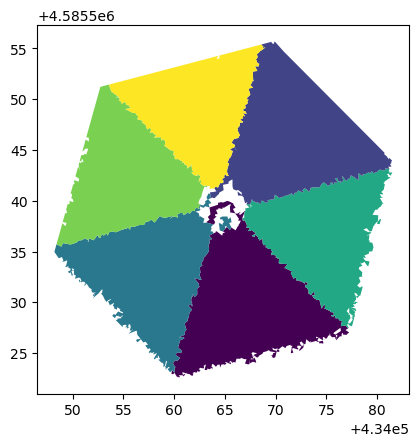

In [143]:
# Construction level
parcel = "4157903DF3845E"
construction = 86

parcelSubfolder = parcelsFolder + parcel + "/"
constructionFolder = parcelSubfolder + str(construction)
constructionFile = constructionFolder + "/Plane Identification/"+ str(construction)+".gpkg"
planesGDF = gpd.read_file(constructionFile)
planesGDF.plot(column="cluster")

In [162]:
# Plane level
cluster = 20
lasFile = constructionFolder + "/Plane Identification/"+ str(construction)+".laz"
lasDF = laspy.read(lasFile)

# def sample_points(lasDF, planesGDF, cluster):
selectedPoints = lasDF[lasDF.classification == cluster]
points = selectedPoints.xyz
shapely_points = [Point(p[:2]) for p in points]
geometry = planesGDF[planesGDF.cluster == cluster].geometry.values
inside_points = [point for point, shapely_point in zip(points, shapely_points) if geometry.contains(shapely_point)]

In [197]:
# point level
def get_shading_profile(point):
    Z_point = point[2]+0.05
    tiltangle = np.zeros(X.shape)
    distance = (X[:,:] - point[0])**2 + (Y[:,:] - point[1])**2
    tiltangle = np.arctan2((z[:,:] - Z_point), distance[:,:])*180/math.pi
    tiltangle = np.maximum(tiltangle, 0)
    azimuthAngle = np.zeros(X.shape)
    azimuthAngle = np.arctan2(X[:,:] - point[0], Y[:,:] - point[1])*180/math.pi
    azimuthAngle = np.where(azimuthAngle < 0, azimuthAngle + 360, azimuthAngle)
    azimuthAngle = np.round(azimuthAngle).astype(int)

    azimuthAngle_flat = azimuthAngle.ravel()
    tiltangle_flat = tiltangle.ravel()
    df = pd.DataFrame({
        'azimuth': azimuthAngle_flat,
        'tiltangle': tiltangle_flat
    })

    # Group by azimuth and get the maximum tiltangle for each azimuth
    max_tilt_df = df.groupby('azimuth')['tiltangle'].max().reset_index()

    return max_tilt_df.tiltangle.values

shading_results = []
for idx, point in enumerate(inside_points):
    print(idx)
    shading_results.append(get_shading_profile(point))

shading_results

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


KeyboardInterrupt: 

/tmp/ipykernel_17918/1931860671.py:3: RuntimeWarning: divide by zero encountered in log
  c = ax.pcolormesh(X, Y, np.log(tiltangle), cmap='gray_r', shading='auto')


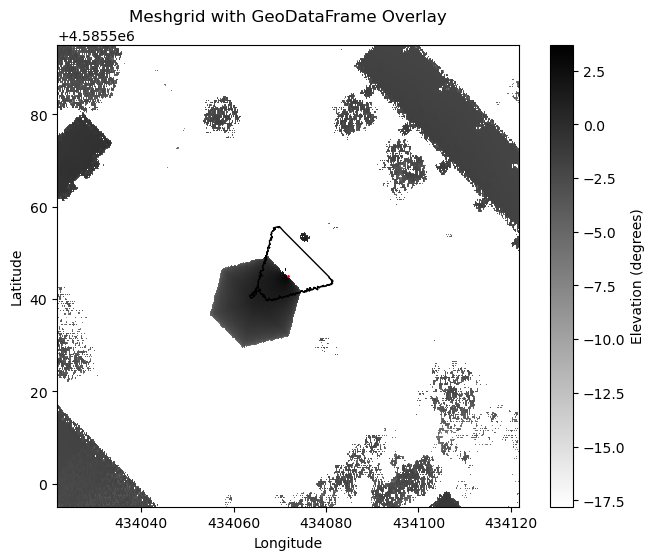

In [193]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(X, Y, np.log(tiltangle), cmap='gray_r', shading='auto')
fig.colorbar(c, ax=ax, label="Elevation (degrees)")


# Plot the GeoDataFrame over the surface plot
planesGDF[planesGDF.cluster==cluster].plot(ax=ax, color="None", edgecolor='black', linewidth=1)

# Adjust axis limits and labels if needed
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Meshgrid with GeoDataFrame Overlay')

ax.set_xlim(point[0]-50, point[0]+50)
ax.set_ylim(point[1]-50, point[1]+50)

ax.scatter(point[0], point[1], s=1, c="red")

# Show the plot
plt.show()

# Get some plots

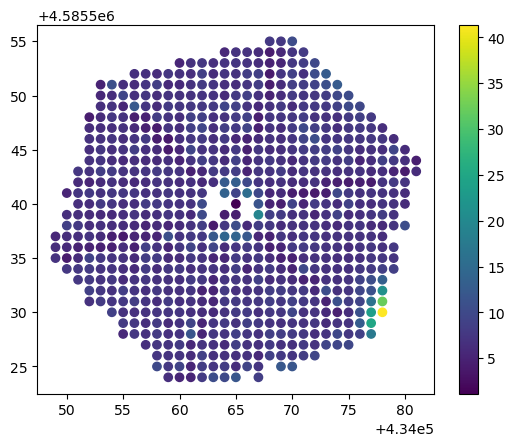

In [251]:
constructionFile = basePath + "Results/Test_70_el Besòs i el Maresme/Parcels/4157903DF3845E/86/Plane Identification/86.gpkg"
planesGDF = gpd.read_file(constructionFile)

shadingPath = basePath + "Results/Test_70_el Besòs i el Maresme/Parcels/4157903DF3845E/86/Shading/"
shadingFiles = ["13.csv", "14.csv", "15.csv", "16.csv", "17.csv", "18.csv"]
# shadingFiles = ["16.csv"]

shadingProfiles = pd.DataFrame()

for shadingFile in shadingFiles:
    filePath = os.path.join(shadingPath, shadingFile)
    temp_df = pd.read_csv(filePath, header=None)  # Read the CSV file
    shadingProfiles = pd.concat([shadingProfiles, temp_df], ignore_index=True)  # Concatenate into the main dataframe

shadingProfiles['avg'] = shadingProfiles.iloc[:, 3:363].mean(axis=1)
shadingProfiles = shadingProfiles.rename(columns={0:"x", 1:"y"})
plt.scatter(shadingProfiles.x, shadingProfiles.y, c=shadingProfiles.avg)
plt.colorbar()

<Axes: >

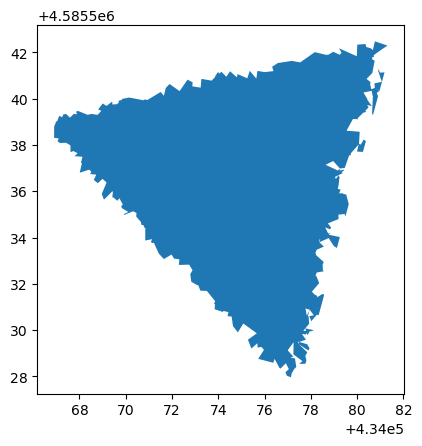

In [196]:
planesGDF[planesGDF.cluster==17].plot()

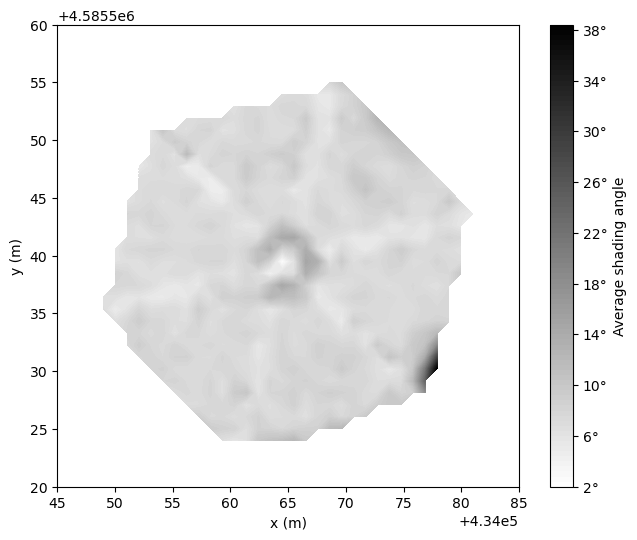

In [258]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Assuming shadingsProfiles is a dictionary-like object
x = shadingProfiles["x"]
y = shadingProfiles["y"]
z = shadingProfiles["avg"]

# Create a grid for x and y
xi = np.linspace(min(x), max(x), math.ceil(max(x)-min(x)))
yi = np.linspace(min(y), max(y), math.ceil(max(y)-min(y)))
xi, yi = np.meshgrid(xi, yi)

# Interpolate z onto the grid
zi = griddata((x, y), z, (xi, yi), method='cubic')

# Plot the mesh
fig, ax = plt.subplots(figsize=(8, 6))

heatmap = plt.contourf(xi, yi, zi, levels=100, cmap='gray_r')
cb = fig.colorbar(heatmap, ax=ax, label="Average shading angle")

cbar_ticks = cb.ax.get_yticks()  # Get current colorbar ticks
cb.ax.set_yticks(cbar_ticks)  # Ensure the same ticks are used
cb.ax.set_yticklabels([f"{tick:.0f}°" for tick in cbar_ticks])  # Add ° to each tick


# planesGDF[planesGDF.cluster == 4].plot(ax=ax, color="None", edgecolor='black', linewidth=1)

centroid = planesGDF[planesGDF.cluster==17].centroid.values[0]
centroid = [434065, 4585540]
minSize=20
ax.set_xlim(centroid[0]-minSize, centroid[0]+minSize)
ax.set_ylim(centroid[1]-minSize, centroid[1]+minSize)

# Add axis labels and title
plt.xlabel("x (m)")
plt.ylabel("y (m)")

# Show the plot
ax.set_aspect("equal", adjustable='box')
plt.savefig("/home/jaumeasensio/Documents/TFM/Redacció memòria/Figures/Shading/ShadingWholeRoof.png",bbox_inches='tight')
plt.show()